In [6]:
install.packages("tidyverse", repos = "https://cloud.r-project.org")
# install.packages("fixest", repos = "https://cloud.r-project.org")
# install.packages("broom", repos = "https://cloud.r-project.org")
# install.packages("knitr", repos = "https://cloud.r-project.org")
# install.packages("scales", repos = "https://cloud.r-project.org")

Warning message:
"package 'tidyverse' is in use and will not be installed"


In [7]:
# =============================================================================
# SETUP: Load Required Libraries
# =============================================================================
library(tidyverse)
library(fixest)
library(broom)
library(knitr)
library(scales)

theme_set(theme_minimal(base_size = 14))
cat("Libraries loaded successfully!\n")

Libraries loaded successfully!


In [8]:
# =============================================================================
# DATA LOADING
# =============================================================================
url <- "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
df <- read.csv(url)

# Normalize column names
if ('_nfd' %in% names(df)) df <- df %>% rename(X_nfd = `_nfd`)

# Create treatment indicator (ever-treated)
df <- df %>% mutate(X_treated = ifelse(!is.na(X_nfd) & X_nfd > 0, 1, 0))

cat("Dataset loaded:", nrow(df), "rows x", ncol(df), "columns\n")
cat("States:", length(unique(df$stfips)), "| Years:", min(df$year), "-", max(df$year), "\n")
head(df, 6)

Dataset loaded: 1617 rows x 11 columns
States: 49 | Years: 1964 - 1996 


,stfips,year,X_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop,X_treated
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1964,1971,0,35.63988,12406.18,5.007341,0.012312243,1715156,1715156,1
2,1,1965,1971,0,41.54375,13070.21,4.425367,0.010419407,1715156,1725186,1
3,1,1966,1971,0,34.25233,13526.66,4.874819,0.009900097,1715156,1735219,1
4,1,1967,1971,0,34.46502,13918.19,5.362014,0.009974692,1715156,1745250,1
5,1,1968,1971,0,40.44011,14684.81,4.643759,0.012400659,1715156,1755283,1
6,1,1969,1971,0,42.49012,15638.88,5.296976,0.015006756,1715156,1765316,1


In [9]:
# Examine treatment timing structure
cat("Treatment cohorts (X_nfd = 0 means never-treated):\n")
print(table(df$X_nfd))

# Key variables summary
cat("\nKey Variables Summary:\n")
df %>% 
  summarize(
    `Outcome (asmrs)` = sprintf("%.2f (SD: %.2f)", mean(asmrs), sd(asmrs)),
    `Per Capita Income` = sprintf("%.0f", mean(pcinc)),
    `asmrh mean` = sprintf("%.2f", mean(asmrh)),
    `cases mean` = sprintf("%.2f", mean(cases))
  ) %>% 
  print()

Treatment cohorts (X_nfd = 0 means never-treated):

1969 1970 1971 1972 1973 1974 1975 1976 1977 1980 1984 1985 
  66   66  231   99  330   99   66   33   99   33   33   33 

Key Variables Summary:
    Outcome (asmrs) Per Capita Income asmrh mean cases mean
1 52.17 (SD: 19.62)             26081       3.44       0.02


---

## Part a) Two-Way Fixed Effects (TWFE) Regression

### Model Specification

$$Y_{it} = \\alpha_i + \\gamma_t + \\beta \\cdot D_{it} + X_{it}'\\delta + \\varepsilon_{it}$$

In [10]:
# Create treatment indicator: treated_post = 1 if state is treated AND in post-treatment period
df$treated_post <- ifelse(df$X_nfd > 0 & df$year >= df$X_nfd, 1, 0)

cat("Treatment indicator summary:\n")
table(df$treated_post, dnn = "treated_post")

Treatment indicator summary:


treated_post
  0   1 
345 843 

In [11]:
# =============================================================================
# TWFE ESTIMATION
# =============================================================================
twfe_model <- feols(
  asmrs ~ treated_post + pcinc + asmrh + cases | stfips + year,
  data = df,
  cluster = ~stfips
)

cat("========================================================================\n")
cat("TWO-WAY FIXED EFFECTS (TWFE) REGRESSION RESULTS\n")
cat("========================================================================\n")
summary(twfe_model)

NOTE: 429 observations removed because of NA values (RHS: 429).



TWO-WAY FIXED EFFECTS (TWFE) REGRESSION RESULTS


OLS estimation, Dep. Var.: asmrs
Observations: 1,188
Fixed-effects: stfips: 36,  year: 33
Standard-errors: Clustered (stfips) 
               Estimate Std. Error   t value Pr(>|t|)    
treated_post   2.475811   3.024245  0.818654 0.418523    
pcinc         -0.000726   0.000417 -1.740622 0.090536 .  
asmrh          0.508696   0.371010  1.371113 0.179068    
cases        -96.324096 146.887959 -0.655766 0.516263    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 10.5     Adj. R2: 0.736853
             Within R2: 0.012412

In [12]:
# Create clean coefficient table
twfe_summary <- tidy(twfe_model, conf.int = TRUE) %>%
  mutate(
    significance = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      p.value < 0.1 ~ ".",
      TRUE ~ ""
    )
  )

cat("\n========================================================================\n")
cat("TWFE COEFFICIENT TABLE\n")
cat("========================================================================\n")
print(twfe_summary %>% select(term, estimate, std.error, p.value, conf.low, conf.high, significance))

# Store for later comparison
twfe_coef <- coef(twfe_model)["treated_post"]
twfe_se <- sqrt(vcov(twfe_model)["treated_post", "treated_post"])
cat(sprintf("\n*** Treatment Effect (treated_post): %.4f (SE: %.4f) ***\n", twfe_coef, twfe_se))


TWFE COEFFICIENT TABLE
# A tibble: 4 × 7
  term           estimate  std.error p.value   conf.low  conf.high significance
  <chr>             <dbl>      <dbl>   <dbl>      <dbl>      <dbl> <chr>       
1 treated_post   2.48       3.02      0.419    -3.66      8.62     ""          
2 pcinc         -0.000726   0.000417  0.0905   -0.00157   0.000121 "."         
3 asmrh          0.509      0.371     0.179    -0.244     1.26     ""          
4 cases        -96.3      147.        0.516  -395.      202.       ""          

*** Treatment Effect (treated_post): 2.4758 (SE: 3.0242) ***


---

## Part b) Cleaning for Event-Study

### b.1) Create Relative Time Variable

In [13]:
# =============================================================================
# CREATE EVENT TIME (RELATIVE TIME) VARIABLE
# =============================================================================
df <- df %>%
  mutate(
    treatment_year = X_nfd,
    event_time = ifelse(treatment_year > 0, year - treatment_year, NA)
  )

cat("Event time variable created!\n")
cat("Never-treated units have event_time = NA\n\n")

# Show sample of the data
df %>%
  select(stfips, year, treatment_year, event_time, asmrs) %>%
  filter(stfips %in% c(1, 4, 5)) %>%
  arrange(stfips, year) %>%
  head(15)

Event time variable created!
Never-treated units have event_time = NA



,stfips,year,treatment_year,event_time,asmrs
,<int>,<int>,<int>,<int>,<dbl>
1,1,1964,1971,-7,35.63988
2,1,1965,1971,-6,41.54375
3,1,1966,1971,-5,34.25233
4,1,1967,1971,-4,34.46502
5,1,1968,1971,-3,40.44011
6,1,1969,1971,-2,42.49012
7,1,1970,1971,-1,44.23907
8,1,1971,1971,0,49.91467
9,1,1972,1971,1,47.20313


### b.2) Frequency Table of Event Time

In [14]:
# =============================================================================
# FREQUENCY TABLE OF EVENT TIME
# =============================================================================
event_time_freq <- df %>%
  filter(!is.na(event_time)) %>%
  count(event_time) %>%
  arrange(event_time) %>%
  mutate(
    pct = round(n / sum(n) * 100, 1),
    cum_pct = round(cumsum(pct), 1)
  )

cat("========================================================================\n")
cat("FREQUENCY TABLE OF EVENT TIME (RELATIVE TIME)\n")
cat("========================================================================\n")
print(event_time_freq)

cat(sprintf("\nTotal treated observations: %d\n", sum(event_time_freq$n)))
cat(sprintf("Never-treated observations: %d\n", sum(is.na(df$event_time))))

# Save frequency table
write.csv(event_time_freq, "../output/salida_1.csv", row.names = FALSE)
cat("\n✓ Tabla de frecuencias guardada en: ../output/salida_1.csv\n")

FREQUENCY TABLE OF EVENT TIME (RELATIVE TIME)
   event_time  n pct cum_pct
1         -21  1 0.1     0.1
2         -20  2 0.2     0.3
3         -19  2 0.2     0.5
4         -18  2 0.2     0.7
5         -17  2 0.2     0.9
6         -16  3 0.3     1.2
7         -15  3 0.3     1.5
8         -14  3 0.3     1.8
9         -13  6 0.5     2.3
10        -12  7 0.6     2.9
11        -11  9 0.8     3.7
12        -10 12 1.0     4.7
13         -9 22 1.9     6.6
14         -8 25 2.1     8.7
15         -7 32 2.7    11.4
16         -6 34 2.9    14.3
17         -5 36 3.0    17.3
18         -4 36 3.0    20.3
19         -3 36 3.0    23.3
20         -2 36 3.0    26.3
21         -1 36 3.0    29.3
22          0 36 3.0    32.3
23          1 36 3.0    35.3
24          2 36 3.0    38.3
25          3 36 3.0    41.3
26          4 36 3.0    44.3
27          5 36 3.0    47.3
28          6 36 3.0    50.3
29          7 36 3.0    53.3
30          8 36 3.0    56.3
31          9 36 3.0    59.3
32         10 36 3.0    62

### b.3) Choosing Bounds for Binning

In [15]:
# Analyze distribution to choose bounds
event_times <- df$event_time[!is.na(df$event_time)]

cat("Event time range:", min(event_times), "to", max(event_times), "\n\n")
cat("Percentiles:\n")
print(quantile(event_times, probs = c(0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95)))

cat("\nObservations at extremes:\n")
cat(sprintf("  event_time <= -10: %d (%.1f%%)\n", 
            sum(event_times <= -10), sum(event_times <= -10)/length(event_times)*100))
cat(sprintf("  event_time >= 10:  %d (%.1f%%)\n", 
            sum(event_times >= 10), sum(event_times >= 10)/length(event_times)*100))

# Set bounds
LOWER_BOUND <- -10
UPPER_BOUND <- 10
cat("\n>>> Bounds seleccionados: LOWER_BOUND =", LOWER_BOUND, ", UPPER_BOUND =", UPPER_BOUND, "\n")

Event time range: -21 to 27 

Percentiles:
 5% 10% 25% 50% 75% 90% 95% 
 -9  -7  -2   6  15  20  22 

Observations at extremes:
  event_time <= -10: 52 (4.4%)
  event_time >= 10:  483 (40.7%)

>>> Bounds seleccionados: LOWER_BOUND = -10 , UPPER_BOUND = 10 


### b.4) Create Relative-Time Factor Variable

In [16]:
# =============================================================================
# CREATE BINNED EVENT TIME AND FACTOR VARIABLE
# =============================================================================
df_es <- df %>%
  filter(treatment_year > 0) %>%
  mutate(
    event_time_binned = pmin(pmax(event_time, LOWER_BOUND), UPPER_BOUND),
    event_time_factor = factor(event_time_binned),
    event_time_factor = relevel(event_time_factor, ref = "-1")  # t = -1 is reference
  )

cat("Event time factor created with t = -1 as REFERENCE (omitted) category\n\n")
cat("Factor levels:\n")
print(levels(df_es$event_time_factor))
cat(sprintf("\nObservations for event study: %d\n", nrow(df_es)))

Event time factor created with t = -1 as REFERENCE (omitted) category

Factor levels:
 [1] "-1"  "-10" "-9"  "-8"  "-7"  "-6"  "-5"  "-4"  "-3"  "-2"  "0"   "1"  
[13] "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10" 

Observations for event study: 1188


---

## Part c) Event-Study Estimation

### Event-Study Model

$$Y_{it} = \\alpha_i + \\gamma_t + \\sum_{k \\neq -1} \\beta_k \\cdot \\mathbf{1}[K_{it} = k] + X_{it}'\\delta + \\varepsilon_{it}$$

In [17]:
# =============================================================================
# EVENT-STUDY ESTIMATION
# =============================================================================
event_study_model <- feols(
  asmrs ~ event_time_factor + pcinc + asmrh + cases | stfips + year,
  data = df_es,
  cluster = ~stfips
)

cat("========================================================================\n")
cat("EVENT-STUDY REGRESSION RESULTS\n")
cat("Reference period: t = -1 (one year before treatment)\n")
cat("========================================================================\n")
summary(event_study_model)

EVENT-STUDY REGRESSION RESULTS
Reference period: t = -1 (one year before treatment)


OLS estimation, Dep. Var.: asmrs
Observations: 1,188
Fixed-effects: stfips: 36,  year: 33
Standard-errors: Clustered (stfips) 
                        Estimate Std. Error   t value Pr(>|t|) 
event_time_factor-10   -6.148791   7.718843 -0.796595  0.43106 
event_time_factor-9    -7.318022   6.115817 -1.196573  0.23952 
event_time_factor-8    -4.430764   5.957583 -0.743718  0.46201 
event_time_factor-7    -2.708891   5.819362 -0.465496  0.64446 
event_time_factor-6    -2.136785   4.513974 -0.473371  0.63889 
event_time_factor-5    -3.788089   3.545175 -1.068520  0.29260 
event_time_factor-4    -0.619333   2.840652 -0.218025  0.82868 
event_time_factor-3    -3.139643   2.975579 -1.055137  0.29859 
event_time_factor-2    -0.654568   2.444916 -0.267726  0.79048 
event_time_factor0      1.209878   2.803174  0.431610  0.66867 
event_time_factor1     -0.312555   3.448384 -0.090638  0.92830 
event_time_factor2      0.765940   4.658407  0.164421  0.87035 
event_time_factor3      1.893053   3.5673

In [18]:
# =============================================================================
# EXTRACT AND STORE COEFFICIENTS
# =============================================================================
es_results <- tidy(event_study_model, conf.int = TRUE) %>%
  filter(str_detect(term, "event_time_factor")) %>%
  mutate(
    event_time = as.numeric(str_extract(term, "-?\\d+")),
    coefficient = estimate,
    std_error = std.error,
    ci_lower = conf.low,
    ci_upper = conf.high
  ) %>%
  select(event_time, coefficient, std_error, ci_lower, ci_upper, statistic, p.value)

# Add reference period (t = -1)
reference_row <- tibble(
  event_time = -1, coefficient = 0, std_error = 0,
  ci_lower = 0, ci_upper = 0, statistic = NA_real_, p.value = NA_real_
)

es_results <- bind_rows(es_results, reference_row) %>% arrange(event_time)

cat("========================================================================\n")
cat("EVENT-STUDY COEFFICIENTS TABLE\n")
cat("========================================================================\n")
print(es_results)

# Save to CSV
write.csv(es_results, "../output/salida_2.csv", row.names = FALSE)
cat("\nSaved to: ../output/salida_2.csv")

EVENT-STUDY COEFFICIENTS TABLE
# A tibble: 21 × 7
   event_time coefficient std_error ci_lower ci_upper statistic p.value
        <dbl>       <dbl>     <dbl>    <dbl>    <dbl>     <dbl>   <dbl>
 1        -10      -6.15       7.72   -21.8      9.52    -0.797   0.431
 2         -9      -7.32       6.12   -19.7      5.10    -1.20    0.240
 3         -8      -4.43       5.96   -16.5      7.66    -0.744   0.462
 4         -7      -2.71       5.82   -14.5      9.11    -0.465   0.644
 5         -6      -2.14       4.51   -11.3      7.03    -0.473   0.639
 6         -5      -3.79       3.55   -11.0      3.41    -1.07    0.293
 7         -4      -0.619      2.84    -6.39     5.15    -0.218   0.829
 8         -3      -3.14       2.98    -9.18     2.90    -1.06    0.299
 9         -2      -0.655      2.44    -5.62     4.31    -0.268   0.790
10         -1       0          0        0        0       NA      NA    
# ℹ 11 more rows

Saved to: ../output/salida_2.csv

### Event-Study Plot


✓ Gráfico del event-study guardado en: ../output/salida_3.png


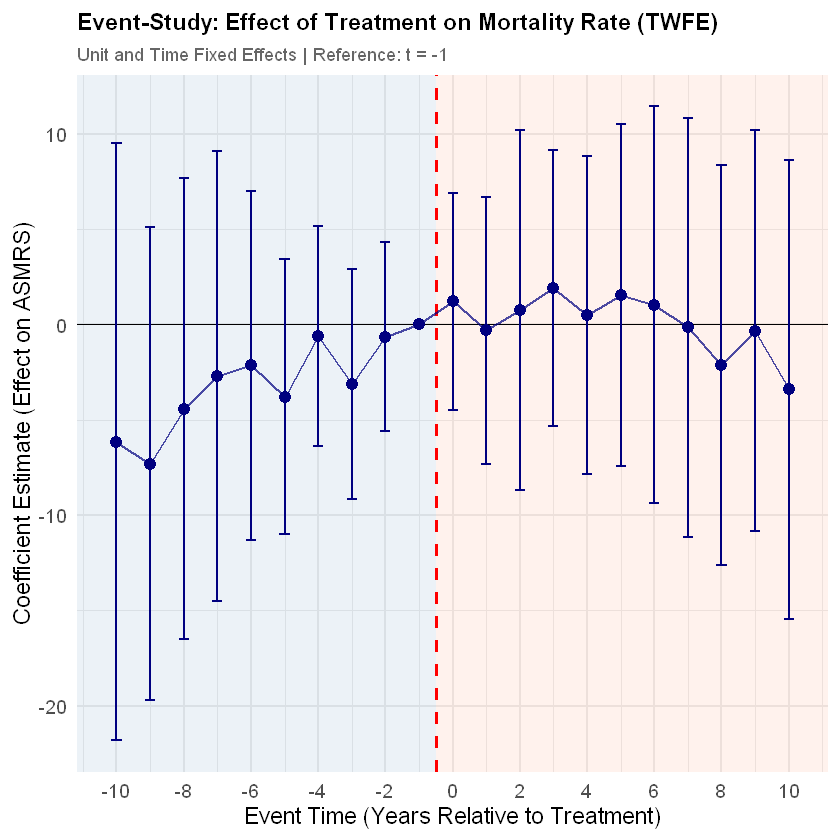

In [19]:
# =============================================================================
# EVENT-STUDY PLOT
# =============================================================================
es_plot <- ggplot(es_results, aes(x = event_time, y = coefficient)) +
  # Shading for pre/post periods
  annotate("rect", xmin = -Inf, xmax = -0.5, ymin = -Inf, ymax = Inf, 
           fill = "steelblue", alpha = 0.1) +
  annotate("rect", xmin = -0.5, xmax = Inf, ymin = -Inf, ymax = Inf, 
           fill = "coral", alpha = 0.1) +
  # Reference lines
  geom_hline(yintercept = 0, color = "black", linewidth = 0.5) +
  geom_vline(xintercept = -0.5, color = "red", linetype = "dashed", linewidth = 1) +
  # Confidence intervals and points
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.3, color = "navy", linewidth = 0.8) +
  geom_line(color = "navy", alpha = 0.7, linewidth = 0.8) +
  geom_point(color = "navy", size = 3) +
  # Labels
  labs(
    title = "Event-Study: Effect of Treatment on Mortality Rate (TWFE)",
    subtitle = "Unit and Time Fixed Effects | Reference: t = -1",
    x = "Event Time (Years Relative to Treatment)",
    y = "Coefficient Estimate (Effect on ASMRS)"
  ) +
  scale_x_continuous(breaks = seq(LOWER_BOUND, UPPER_BOUND, by = 2)) +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    plot.subtitle = element_text(size = 11, color = "gray40")
  )

print(es_plot)
ggsave("../output/salida_3.png", es_plot, width = 12, height = 7, dpi = 300)
cat("\n✓ Gráfico del event-study guardado en: ../output/salida_3.png\n")

---

## Summary

### Key Results

| Metric | Value |
|--------|-------|
| **TWFE Treatment Effect** | Coefficient on `treated_post` from static TWFE regression |
| **Event-Study Reference** | t = -1 (one year before treatment) |
| **Event-Time Window** | [-10, +10] years |

### Output Files Generated

- `salida_1.csv` — Frequency table of event times
- `salida_2.csv` — Event-study coefficient estimates
- `salida_3.png` — Event-study coefficient plot with confidence intervals